### Instalacja potrzebnych bibliotek

In [5]:
pip install ipywidgets #interaktywne widżety HTML dla notebooków Jupyter i jądra IPython

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#interaktywne'


In [6]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Importowanie wymaganych bibliotek

In [8]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

##### Import bibliotek do stworzenia sieci LSTM

In [9]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)

### Wczytanie bazy

In [10]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
data = pd.read_csv('./zmienne/usdpln_d.csv')

### Podzial na zbiór treningowy i testowy

In [11]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(2849, 5)


In [12]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(1709, 5)


In [13]:
# zbiór testowy
ratio = 0.5
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(1140, 5)


In [14]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
count,1709.000000,1709.000000,1709.000000,1709.000000
mean,3.283205,3.304046,3.265029,3.284120
std,0.355510,0.356859,0.352708,0.355198
min,2.646300,2.657000,2.631900,2.638900
25%,3.036700,3.050900,3.027900,3.039300
50%,3.183500,3.204100,3.165700,3.183500
75%,3.512700,3.537900,3.500100,3.527800
max,4.133320,4.155790,4.113940,4.132170


In [15]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [16]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [17]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [18]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

In [19]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Uczenie modelu

In [20]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2)) 
  model.add(Dense(5))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



## Ewaluacja modelu

In [21]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict



In [22]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [23]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/5
135/135 [==============================] - 5s 15ms/step - loss: 0.0310 - val_loss: 0.0059
Epoch 2/5
135/135 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0029
Epoch 3/5
135/135 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 4/5
135/135 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 5/5
135/135 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0016


In [24]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


In [25]:

evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 0.08921564034755507
Train Root Mean Squared Error: 0.10096641278262104


(array([[2.85980014, 2.84680012, 2.8777001 , ..., 3.76939976, 3.76460021,
         3.73879991]]),
 array([[2.973807 , 2.9588609, 2.954455 , 2.9608614, 2.9698002],
        [2.9749553, 2.9523597, 2.9624534, 2.973614 , 2.9679534],
        [2.9774444, 2.9479537, 2.962082 , 2.9740102, 2.9638515],
        ...,
        [3.7986274, 3.7782815, 3.7820706, 3.803575 , 3.7931828],
        [3.8013754, 3.7817605, 3.7715018, 3.819206 , 3.7954898],
        [3.7978384, 3.7786837, 3.7695575, 3.8114407, 3.787997 ]],
       dtype=float32))

In [26]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 0.08921564034755507
Train Root Mean Squared Error: 0.10096641278262104


In [27]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



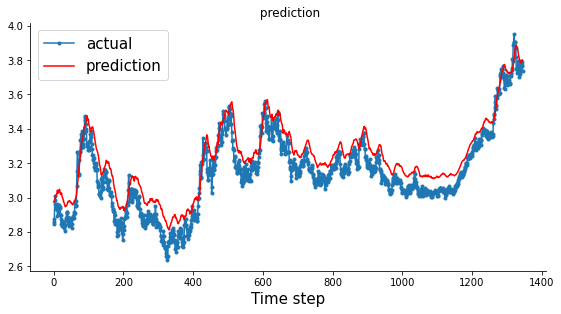

In [28]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict) # niebieska- z csv wiersze i do nich wartości z pliku excel (na podstawie ratio nie cale 2849 tylko 0.6 z tego); czerwone- dla poszczegolnych wierszy błędy; model dobrze się uczy

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [29]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.7201642  0.7194947  0.7237805 ]
 [0.7194947  0.7237805  0.7081102 ]
 [0.7237805  0.7081102  0.72130287]
 ...
 [0.8178359  0.81308115 0.80045784]
 [0.81308115 0.80045784 0.7865623 ]
 [0.80045784 0.7865623  0.79493296]]


In [30]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
137/137 [==============================] - 3s 6ms/step - loss: 0.0456 - val_loss: 0.0483
Epoch 2/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0197
Epoch 3/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 4/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 5/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0014
Train Mean Absolute Error: 0.03918471572787696
Train Root Mean Squared Error: 0.05038900644927776
-------------------------------31--------------------------
Epoch 1/5
137/137 [==============================] - 3s 6ms/step - loss: 0.0428 - val_loss: 0.0486
Epoch 2/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0234
Epoch 3/5
137/137 [==============================] - 0s 3ms/step - loss: 0.0091 - val_los

Epoch 4/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 5/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0011
Train Mean Absolute Error: 0.049931555234867774
Train Root Mean Squared Error: 0.06169772218305304
-------------------------------33--------------------------
Epoch 1/5
136/136 [==============================] - 3s 7ms/step - loss: 0.0435 - val_loss: 0.0031
Epoch 2/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 3/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 4/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 5/5
136/136 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0012
Train Mean Absolute Error: 0.04859244028074932
Train Root Mean Squared Error: 0.061967095515022
-------------------------------34-------------------

134/134 [==============================] - 3s 7ms/step - loss: 0.0372 - val_loss: 0.0035
Epoch 2/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 3/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0021
Epoch 4/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0018
Epoch 5/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0016
Train Mean Absolute Error: 0.12441460258901615
Train Root Mean Squared Error: 0.13557798043788544
-------------------------------36--------------------------
Epoch 1/5
134/134 [==============================] - 3s 7ms/step - loss: 0.0241 - val_loss: 0.0041
Epoch 2/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0039
Epoch 3/5
134/134 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0028
Epoch 4/5
134/134 [==============================] - 0s 3ms/

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [31]:
# wyświetlenie liczby kolumn i wierszy; 2849:1346= 2,1 , a więc 20% (a wcześniej ratio 0.8), więc tak przyjął; model treningowy z predykcją (czerwona linia na wykresie)
train_predict.shape

(1346, 5)

In [32]:
error_look_back[3]["MSE"]

[0.05038900644927776,
 0.05389450569649733,
 0.05358299191757565,
 0.04474204884742088,
 0.050078416487082444,
 0.049561961729617826,
 0.06163747710293437,
 0.04369076155768456,
 0.04684320700820519,
 0.06585801524970489]

In [37]:
error_look_back[3]["MAE"]

[0.03918471572787696,
 0.04335833300943795,
 0.042415361353697056,
 0.03477414880444981,
 0.04003973862953999,
 0.03889247152658853,
 0.048515523927034745,
 0.034472796853884775,
 0.0362564240143911,
 0.05188506427720725]

In [33]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[0.11863215525693649, 0.12213664999324603, 0.12339914145838546, 0.12674843479360787, 0.12852990029400646, 0.1338407098092729, 0.13557798043788544, 0.1400033721251243, 0.14127178855864023, 0.14840556324106094]


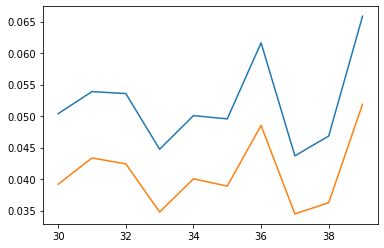

In [39]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3 
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


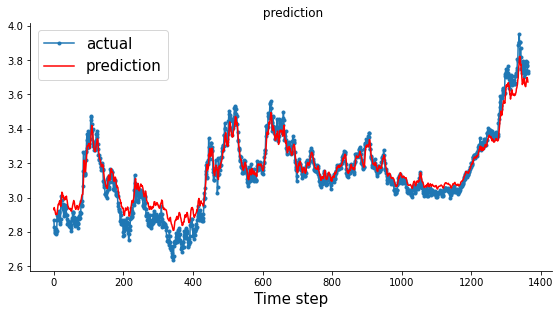

In [40]:
batch_index = 6 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3 #jak to wyrzucimy, to tez bedzie dzialac
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [36]:
error_look_back[3]["Y_trains"][0]

array([[2.87050007, 2.82699989, 2.79999996, ..., 3.76460021, 3.73879991,
        3.72299995]])